# Plotting & Region of Interest 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from herbie import Herbie
import numpy as np

In [3]:
H = Herbie(
    "2021-07-01 12:00",  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=0,  # forecast lead time
)

H.download(":VIL:")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Jul-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


PosixPath('/Users/thinhhoang/data/hrrr/20210701/subset_e7ef0967__hrrr.t12z.wrfsfcf00.grib2')

In [4]:
ds = H.xarray(":VIL:")
vil = ds.veril

/Users/thinhhoang/miniforge3/envs/traffic/lib/python3.9/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [5]:
vil['latitude'].values.shape

(1059, 1799)

In [6]:
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Lambert = ccrs.LambertConformal()

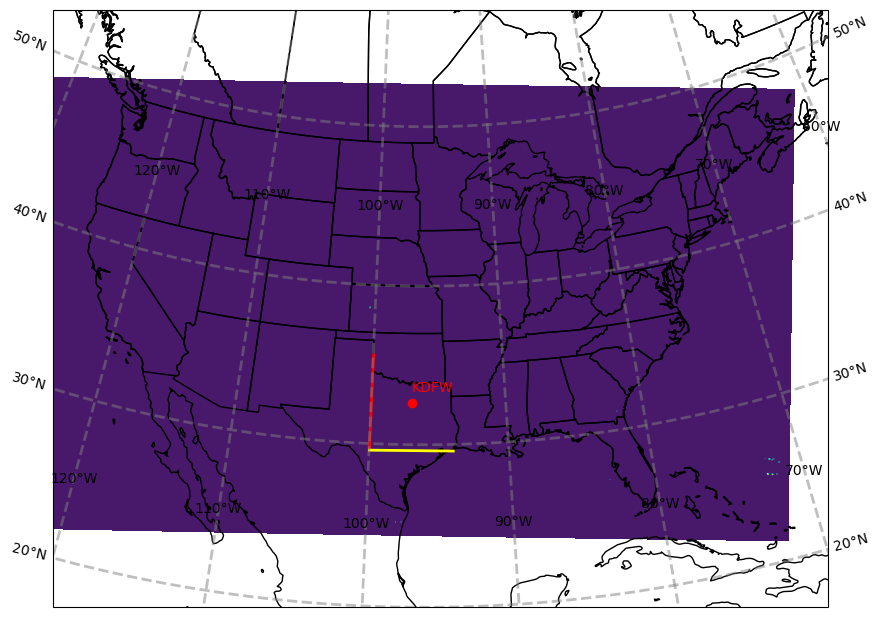

In [7]:
from roi import KDFW, WX_ROI
# Plot the veril using cartopy

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=Lambert)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.STATES)

# Set the map bounds
ax.set_extent([-120, -70, 20, 55], crs=ccrs.PlateCarree())

# Draw two lines, one for each meridian and parallel that we want to highlight.
ax.plot([WX_ROI[0][0], WX_ROI[0][0]], [WX_ROI[1][0], WX_ROI[1][1]], color='red', transform=ccrs.PlateCarree(), linewidth=2)
ax.plot([WX_ROI[0][0], WX_ROI[0][1]], [WX_ROI[1][0], WX_ROI[1][0]], color='yellow', transform=ccrs.PlateCarree(), linewidth=2)

plt.contourf(vil['longitude'].values, vil['latitude'].values, vil.values, transform=ccrs.PlateCarree())
plt.scatter(KDFW[0], KDFW[1], color='red', transform=ccrs.PlateCarree())
plt.text(KDFW[0], KDFW[1]+0.75, 'KDFW', color='red', transform=ccrs.PlateCarree())

# Show the longitude and latitude grid lines
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')



Get the dimensions of the ROI in meters

In [8]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in meters
    R = 6371000
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Latitude and longitude differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return distance

def calculate_dimensions(lat_min_max, lon_min_max):
    lat_min, lat_max = lat_min_max
    lon_min, lon_max = lon_min_max
    # Length is the distance between the two latitudes
    length = haversine(lat_min, lon_min, lat_max, lon_min)
    # Width is the distance between the two longitudes at the midpoint of latitudes
    mid_lat = (lat_min + lat_max) / 2
    width = haversine(mid_lat, lon_min, mid_lat, lon_max)
    return length, width

print(calculate_dimensions(WX_ROI[1], WX_ROI[0]), ' meters (N, E)') # lat, lon

(667169.5598673526, 562082.3228548418)  meters (N, E)


# Writing the Latitude and Longitude Grid Points to a File

In [9]:
# Forming a mask of the ROI
roi_lon = WX_ROI[0]
roi_lat = WX_ROI[1]

mask_lon = np.logical_and(vil['longitude'].values - 360 > roi_lon[0], vil['longitude'].values - 360 < roi_lon[1])
mask_lat = np.logical_and(vil['latitude'].values > roi_lat[0], vil['latitude'].values < roi_lat[1])

mask = np.logical_and(mask_lon, mask_lat)

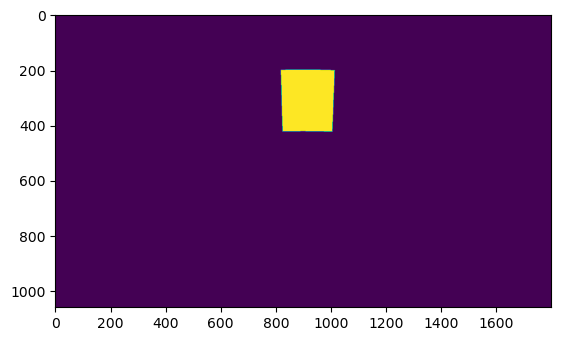

In [10]:
plt.imshow(mask)

In [11]:
# First row index of "True" in mask
mask_lat_id = np.min(np.where(mask == True)[0])
print('First row index of "True" in mask: ', mask_lat_id)
# First column index of "True" in mask
mask_lon_id = np.min(np.where(mask == True)[1])
print('First column index of "True" in mask: ', mask_lon_id)
# Last row index of "True" in mask
mask_lat_id_last = np.max(np.where(mask == True)[0])
print('Last row index of "True" in mask: ', mask_lat_id_last)
# Last column index of "True" in mask
mask_lon_id_last = np.max(np.where(mask == True)[1])
print('Last column index of "True" in mask: ', mask_lon_id_last)

First row index of "True" in mask:  198
First column index of "True" in mask:  819
Last row index of "True" in mask:  422
Last column index of "True" in mask:  1014


In [12]:
lat_roi = np.where(mask, vil['latitude'].values, np.nan)
lon_roi = np.where(mask, vil['longitude'].values, np.nan)
lat_roi_cropped = lat_roi[mask_lat_id:mask_lat_id_last, mask_lon_id:mask_lon_id_last]
lon_roi_cropped = lon_roi[mask_lat_id:mask_lat_id_last, mask_lon_id:mask_lon_id_last]

In [13]:
lon_roi = vil['longitude'].values[mask]
lat_roi = vil['latitude'].values[mask]
vil_roi = vil.values[mask]

In [14]:
latlongrid = {
    'longitude': lon_roi - 360,
    'latitude': lat_roi,
    'lat_coord': lat_roi_cropped,
    'lon_coord': lon_roi_cropped,
    'mask': mask,
    'roi': WX_ROI,
    'kdfw': KDFW,
    'KDFW': KDFW,
    'roi_id': ((mask_lat_id, mask_lat_id_last), (mask_lon_id, mask_lon_id_last))
}

In [15]:
import pickle

with open('preamble.pkl', 'wb') as f:
    pickle.dump(latlongrid, f)
    
print('Latitude and longitude grid saved to preamble.pkl')

Latitude and longitude grid saved to preamble.pkl


In [17]:
vil['longitude'] - 360

<xarray.DataArray 'longitude' (y: 1059, x: 1799)>
array([[-122.719528  , -122.69286132, -122.6661903 , ...,  -72.3430592 ,
         -72.31638668,  -72.28971849],
       [-122.72702499, -122.70035119, -122.67367305, ...,  -72.33557892,
         -72.30889927,  -72.28222397],
       [-122.73452632, -122.7078454 , -122.68116014, ...,  -72.3280943 ,
         -72.30140753,  -72.2747251 ],
       ...,
       [-134.0648096 , -134.02828423, -133.99174671, ...,  -61.02092594,
         -60.9843842 ,  -60.94785462],
       [-134.08013858, -134.04360126, -134.00705178, ...,  -61.00562502,
         -60.96907132,  -60.93252978],
       [-134.09547973, -134.05893046, -134.02236901, ...,  -60.99031194,
         -60.95374627,  -60.91719277]])
Coordinates:
    time        datetime64[ns] 2021-07-01T12:00:00
    step        timedelta64[ns] 00:00:00
    atmosphere  float64 0.0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x